In [1]:
!pip install livelossplot --quiet

In [2]:
# Importing the libraries
import os
import shutil
import glob
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import cv2
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random
from random import seed
from livelossplot import PlotLossesKeras
import math

In [3]:
# Importing the Training Dataset
df_train = pd.read_csv("../input/jpeg-melanoma-384x384/train.csv")
df_train.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,height
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0,0,6000,4000
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0,0,6000,4000
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0,6,1872,1053
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0,0,1872,1053
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0,11,6000,4000


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33126 entries, 0 to 33125
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_name                     33126 non-null  object 
 1   patient_id                     33126 non-null  object 
 2   sex                            33061 non-null  object 
 3   age_approx                     33058 non-null  float64
 4   anatom_site_general_challenge  32599 non-null  object 
 5   diagnosis                      33126 non-null  object 
 6   benign_malignant               33126 non-null  object 
 7   target                         33126 non-null  int64  
 8   tfrecord                       33126 non-null  int64  
 9   width                          33126 non-null  int64  
 10  height                         33126 non-null  int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 2.8+ MB


In [5]:
# Importing the Test Dataset
df_test = pd.read_csv("../input/jpeg-melanoma-384x384/test.csv")
df_test.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,width,height
0,ISIC_0052060,IP_3579794,male,70.0,NaN,6000,4000
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity,6000,4000
2,ISIC_0058510,IP_7960270,female,55.0,torso,6000,4000
3,ISIC_0073313,IP_6375035,female,50.0,torso,6000,4000
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity,1920,1080


In [6]:
# Creating a config class to store all the configurations
class config:
    
    # Image and Tabular data paths
    DIRECTORY_PATH = "../input/jpeg-melanoma-384x384/"
    TRAINING_SAMPLES_FOLDER = DIRECTORY_PATH + "train/"
    TESTING_SAMPLES_FOLDER = DIRECTORY_PATH + "test/"
    TRAIN_FULL_DATA = DIRECTORY_PATH + "train.csv"
    TEST_FULL_DATA = DIRECTORY_PATH + "test.csv"
    
    # New directory path for image data
    WORK_DIRECTORY = "dataset/"
    TRAIN_IMAGES_FOLDER = WORK_DIRECTORY + "training_set/"
    TEST_IMAGES_FOLDER = WORK_DIRECTORY + "test_set/"
    VALIDATION_IMAGES_FOLDER = WORK_DIRECTORY + "validation_set/"
    
    # Input parameters for data preprocessing
    TARGET_NAME = "target"
    TRAIN_SIZE = 0.80
    VALIDATION_SIZE = 0.10
    TEST_SIZE = 0.10
    SEED = 42
    
    # Tensorflow settings for model training
    IMAGE_HEIGHT = 299
    IMAGE_WIDTH = 299
    NO_CHANNELS = 3
    BATCH_SIZE = 64
    EPOCHS = 20
    DROPOUT = 0.5
    LEARNING_RATE = 0.01
    PATIENCE = 5

In [7]:
# Checking the files along with the number of samples
print(os.listdir(config.DIRECTORY_PATH))
print(len(os.listdir(config.TRAINING_SAMPLES_FOLDER)), "Training Samples")
print(len(os.listdir(config.TESTING_SAMPLES_FOLDER)), "Testing Samples")

['sample_submission.csv', 'train.csv', 'test.csv', 'test', 'train']
33126 Training Samples
10982 Testing Samples


In [8]:
# Creating folders for training and validation data
dataset_home = "./dataset/"
subdirs = ["training_set/", "test_set/", "validation_set/"]
for subdir in subdirs:
    labeldirs = ["benign", "malignant"]
    for labeldir in labeldirs:
        newdir = dataset_home + subdir + labeldir
        os.makedirs(newdir, exist_ok=True)

In [9]:
print(os.listdir("./dataset"))

['training_set', 'validation_set', 'test_set']


In [10]:
# Splitting the dataset into train, test and validation set

test_examples = train_examples = validation_examples = 0
seed(config.SEED)

for record in open(config.TRAIN_FULL_DATA).readlines()[1:]:
    split_record = record.split(",")
    image_name = split_record[0]
    target = split_record[7]
    
    random_num = random.random()
    
    if random_num < config.TRAIN_SIZE:
        destination = config.TRAIN_IMAGES_FOLDER
        train_examples += 1
        
    elif random_num < 0.9:
        destination = config.VALIDATION_IMAGES_FOLDER
        validation_examples += 1
        
    else:
        destination = config.TEST_IMAGES_FOLDER
        test_examples += 1
        
    if target == "0":
        shutil.copy(
            config.TRAINING_SAMPLES_FOLDER + image_name + ".jpg",
            destination + "benign/" + image_name + ".jpg"
        )
    
    elif target == "1":
        shutil.copy(
            config.TRAINING_SAMPLES_FOLDER + image_name + ".jpg",
            destination + "malignant/" + image_name + ".jpg"
        )

print(f"Number of training examples: {train_examples}")
print(f"Number of test examples: {test_examples}")
print(f"Number of validation examples: {validation_examples}")

Number of training examples: 26529
Number of test examples: 3286
Number of validation examples: 3311


In [11]:
# Preparing the data and performing Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=(0.95, 0.95),
    rotation_range=15,
    horizontal_flip=True,
    vertical_flip=True,
    data_format="channels_last",
    dtype=tf.float32
)

validation_datagen = ImageDataGenerator(
    rescale=1./255,
    dtype=tf.float32
)

train_generator = train_datagen.flow_from_directory(
    directory=config.TRAIN_IMAGES_FOLDER,
    target_size=(config.IMAGE_HEIGHT, config.IMAGE_WIDTH),
    color_mode="rgb",
    batch_size=config.BATCH_SIZE,
    class_mode="binary",
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    directory=config.VALIDATION_IMAGES_FOLDER,
    target_size=(config.IMAGE_HEIGHT, config.IMAGE_WIDTH),
    color_mode="rgb",
    batch_size=config.BATCH_SIZE,
    class_mode="binary",
    shuffle=True
)

Found 26529 images belonging to 2 classes.
Found 3311 images belonging to 2 classes.


In [12]:
# Creating an exponential learning rate scheduler
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=config.LEARNING_RATE, s=20)
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [13]:
# Using callbacks to save model parameters and perform early stopping
checkpoint_cb = keras.callbacks.ModelCheckpoint("melanoma.h5", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=config.PATIENCE, restore_best_weights=True)

In [14]:
# Calculating the different step size for the model while training
STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALIDATION = validation_generator.n // validation_generator.batch_size

In [15]:
# Metrics to use for compiling the model
METRICS = [keras.metrics.AUC(name="auc")]

2021-11-28 02:18:24.140534: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-28 02:18:24.259344: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-28 02:18:24.260125: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-28 02:18:24.262056: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [16]:
# Calculating the number of benign/malignant images
total_images = train_examples + validation_examples
benign_images = len(os.listdir(config.TRAIN_IMAGES_FOLDER + "benign")) + len(os.listdir(config.VALIDATION_IMAGES_FOLDER + "benign"))
malignant_images = len(os.listdir(config.TRAIN_IMAGES_FOLDER + "malignant")) + len(os.listdir(config.VALIDATION_IMAGES_FOLDER + "malignant"))

In [17]:
# Building a transfer learning model using Keras
xception = keras.applications.xception.Xception(input_shape=(config.IMAGE_HEIGHT, config.IMAGE_WIDTH, config.NO_CHANNELS),
                                       weights="imagenet", include_top=False)
xception.trainable = False

xcept_model = keras.models.Sequential([
    xception,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(8, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
])

83697664/83683744 [==============================] - 1s 0us/step


In [18]:
# Compiling the transfer learning model
xcept_model.compile(optimizer=keras.optimizers.Adam(), 
              loss=keras.losses.BinaryCrossentropy(),
              metrics=METRICS
             )

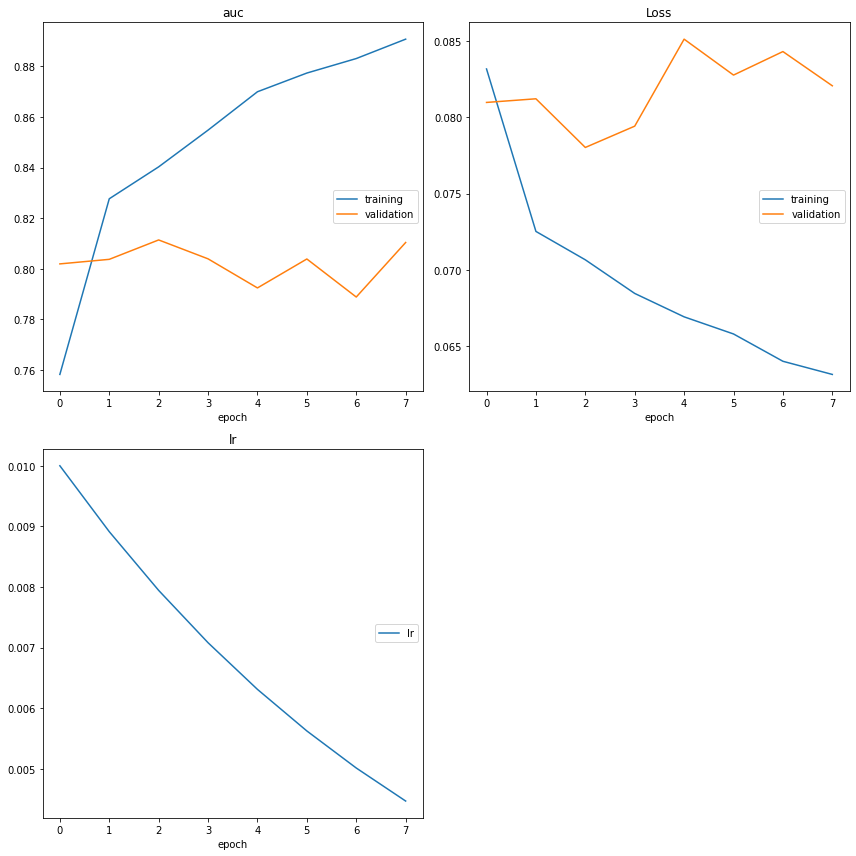

auc
	training         	 (min:    0.758, max:    0.891, cur:    0.891)
	validation       	 (min:    0.789, max:    0.811, cur:    0.810)
Loss
	training         	 (min:    0.063, max:    0.083, cur:    0.063)
	validation       	 (min:    0.078, max:    0.085, cur:    0.082)
lr
	lr               	 (min:    0.004, max:    0.010, cur:    0.004)


In [19]:
# Training the CNN model
xcept_history = xcept_model.fit(train_generator, steps_per_epoch=STEP_SIZE_TRAIN, epochs=config.EPOCHS,
                  validation_data=validation_generator, validation_steps=STEP_SIZE_VALIDATION,
                  callbacks=[early_stopping_cb, checkpoint_cb, lr_scheduler, PlotLossesKeras()]
                 )

In [20]:
# Evaluating the model on Validation Dataset
xcept_model.evaluate(validation_generator, steps=STEP_SIZE_VALIDATION)

51/51 [==============================] - 19s 376ms/step - loss: 0.0796 - auc: 0.8065


[0.07955460250377655, 0.8064647912979126]

In [21]:
# Creating a test generator for test data
test_datagen = ImageDataGenerator(
    rescale=1./255,
    dtype=tf.float32
)

test_generator = test_datagen.flow_from_directory(
    directory=config.TEST_IMAGES_FOLDER,
    target_size=(config.IMAGE_HEIGHT, config.IMAGE_WIDTH),
    color_mode="rgb",
    batch_size=config.BATCH_SIZE,
    class_mode="binary",
    shuffle=False
)

Found 3286 images belonging to 2 classes.


In [22]:
STEP_SIZE_TEST = test_generator.n // test_generator.batch_size

In [23]:
# Getting the actual classes of the test dataset
y_test = np.array([])
num_batches = 0
for _, y in test_generator:
    y_test = np.append(y_test, y)
    num_batches += 1
    if num_batches == math.ceil(test_examples / config.BATCH_SIZE):
        break
y_test

array([0., 0., 0., ..., 1., 1., 1.])

In [24]:
# Predicting output on the test dataset
y_pred = xcept_model.predict(test_generator)
y_pred

array([[0.04638468],
       [0.00320681],
       [0.0086972 ],
       ...,
       [0.29778004],
       [0.01495265],
       [0.09948719]], dtype=float32)

In [25]:
# Computing the TPR and FPR values from the roc curve
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

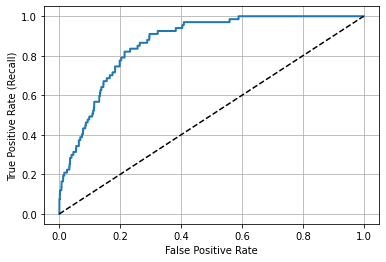

In [26]:
# Plotting the ROC curve
def plot_roc_curve (fpr, tpr, label = None):
    plt.plot(fpr, tpr, linewidth = 2, label = label)
    plt.plot([0,1], [0,1], 'k--') # Dashed diagonal
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.grid()
    
plot_roc_curve(fpr, tpr)
plt.show()

In [27]:
# Evaluating the model on test dataset
xcept_model.evaluate(test_generator, steps=STEP_SIZE_TEST)

51/51 [==============================] - 19s 366ms/step - loss: 0.0603 - auc: 0.8459


[0.060340698808431625, 0.8458700180053711]

In [28]:
# Saving the best model after training
xcept_model.save("final_melanoma_model.h5")

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
